Data Loading and Feature Extraction


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU only

import tensorflow as tf
print("Using GPU?", tf.config.list_physical_devices('GPU'))  # Should show empty list

from keras import backend as K
K.clear_session()  # Clear previous models from memory


Using GPU? []


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam


In [3]:
# Constants
DATA_PATH = r'C:\Users\manim\OneDrive\Desktop\Mani_ma\Projects\Emotion and Tone Detection_Tess Dataset\TESS'
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

def get_emotion(filename):
    for emotion in EMOTIONS:
        if emotion in filename.lower():
            return emotion
    return None

def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        return mfccs_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Build dataset
features = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.wav'):
        emotion = get_emotion(file)
        if emotion:
            path = os.path.join(DATA_PATH, file)
            mfccs = extract_features(path)
            if mfccs is not None:
                features.append([mfccs, emotion])

df = pd.DataFrame(features, columns=['features', 'emotion'])
print("Samples Loaded:", len(df))


Samples Loaded: 1400


Encode Labels and Split the Dataset

In [4]:
X = np.array(df['features'].tolist())
y = np.array(df['emotion'])

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Save the encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Reshape for Conv1D input
X_train = X_train.reshape(X_train.shape[0], 40, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 1)


Model Definition & Training

In [5]:
model = Sequential()

model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(40, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 classes

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 batch_normalization (BatchN  (None, 36, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [6]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Lower learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile again with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Updated early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,  # longer patience
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,  # try a moderate batch size on CPU
    callbacks=[early_stop]
)


Epoch 1/50
140/140 [==============================] - 3s 8ms/step - loss: 1.8841 - accuracy: 0.2161 - val_loss: 1.7547 - val_accuracy: 0.3214
Epoch 2/50
140/140 [==============================] - 1s 5ms/step - loss: 1.6374 - accuracy: 0.4161 - val_loss: 1.4235 - val_accuracy: 0.6250
Epoch 3/50
140/140 [==============================] - 1s 5ms/step - loss: 1.3475 - accuracy: 0.5384 - val_loss: 1.0470 - val_accuracy: 0.7571
Epoch 4/50
140/140 [==============================] - 1s 5ms/step - loss: 1.0822 - accuracy: 0.6179 - val_loss: 0.7536 - val_accuracy: 0.8893
Epoch 5/50
140/140 [==============================] - 1s 5ms/step - loss: 0.8509 - accuracy: 0.7223 - val_loss: 0.5259 - val_accuracy: 0.9286
Epoch 6/50
140/140 [==============================] - 1s 5ms/step - loss: 0.6639 - accuracy: 0.7777 - val_loss: 0.3731 - val_accuracy: 0.9250
Epoch 7/50
140/140 [==============================] - 1s 5ms/step - loss: 0.5651 - accuracy: 0.8125 - val_loss: 0.2844 - val_accuracy: 0.9393
Epoch 

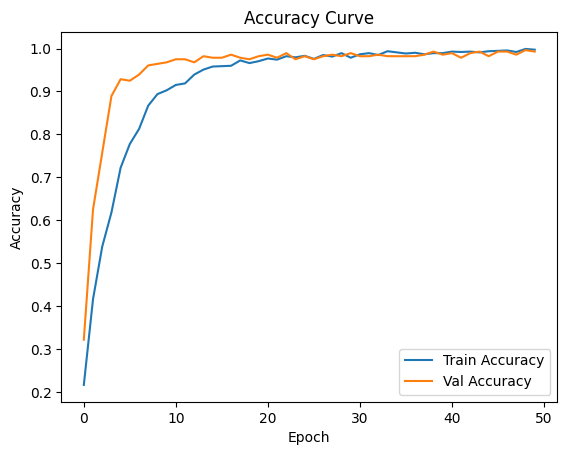

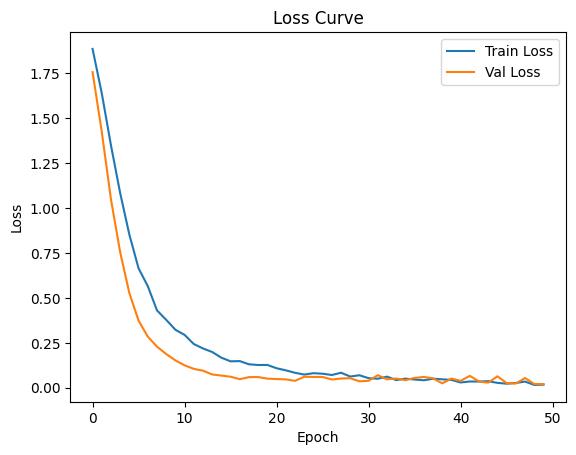

In [7]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.save("tess_emotion_model.h5")
# ---------------- TRAINING ENCODER SAVE CODE ----------------
from sklearn.preprocessing import LabelEncoder
import pickle

# Suppose y is your target list of labels like ['happy', 'sad', 'angry', ...]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Save LabelEncoder for future use
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=8)  # use small batch size
print("Test Accuracy:", test_acc)

35/35 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9929
Test Accuracy: 0.9928571581840515


In [ ]:
import librosa
import numpy as np
import sounddevice as sd
import tensorflow as tf
from keras.models import load_model
import pickle
import scipy.io.wavfile as wavfile

# Load your model and encoder
MODEL_PATH = "tess_emotion_model.h5"
ENCODER_PATH = "label_encoder.pkl"

model = load_model(MODEL_PATH)

# Load LabelEncoder
with open(ENCODER_PATH, "rb") as f:
    le = pickle.load(f)

def record_audio(duration=10, fs=44100, filename="live_audio.wav"):
    print("🎙️ Speak Now...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    wavfile.write(filename, fs, recording)
    print("✅ Recording Done.")
    return filename

def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

    # Fix length: Pad or truncate to shape (40, 174)
    if mfcc.shape[1] < 174:
        pad_width = 174 - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :174]

    return mfcc


def predict_emotion(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    # Take the mean over time-axis (axis=1) to make it (40,)
    mfcc_mean = np.mean(mfcc, axis=1)
    
    # Now shape it to (40, 1)
    features = mfcc_mean.reshape(40, 1)
    
    # Add batch dimension (1, 40, 1)
    features = np.expand_dims(features, axis=1)
    
    # Predict
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction)
    predicted_emotion = le.inverse_transform([predicted_class])[0]
    
    print("Predicted Emotion:", predicted_emotion)


# Run the system
if __name__ == "__main__":
    audio_path = record_audio(duration=5)  # record for 10 seconds
    predict_emotion(audio_path)


🎙️ Speak Now...
✅ Recording Done.
1/1 [==============================] - 0s 298ms/step
Predicted Emotion: disgust
